# Import and misc

In [26]:
#!g1.1


%pip install torchaudio==0.9.1

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.9 MB 2.2 MB/s 
     |████████████████████████████████| 831.4 MB 2.0 kB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.7.0 requires torch==1.6.0, but you have torch 1.9.1 which is incompatible.
mmdet 2.3.0rc0+c6b5ca2 requires Pillow<=6.2.2, but you have pillow 8.4.0 which is incompatible.
mmdet 2.3.0rc0+c6b5ca2 requires torch==1.6.0, but you have torch 1.9.1 which is incompatible.
enot-utils 1.0.2 requires torch==1.6.0, but you have torch 1.9.1 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [27]:
#!g1.1

from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [135]:
#!g1.1

@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [136]:
#!g1.1
# !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# !mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

In [71]:
#!g1.1

class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [72]:
#!g1.1

dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [73]:
#!g1.1

dataset.csv.sample(5)

,path,keyword,label
7225,speech_commands/yes/47d01978_nohash_0.wav,yes,0
16982,speech_commands/tree/8931f494_nohash_0.wav,tree,0
2524,speech_commands/sheila/7e556a2c_nohash_0.wav,sheila,1
57115,speech_commands/stop/2bd2cad5_nohash_1.wav,stop,0
44507,speech_commands/five/9bea2ac7_nohash_0.wav,five,0


### Augmentations

In [74]:
#!g1.1

class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)


In [75]:
#!g1.1

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [76]:
#!g1.1

# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

In [77]:
#!g1.1


### Sampler for oversampling:

In [78]:
#!g1.1

# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [79]:
#!g1.1

train_sampler = get_sampler(train_set.csv['label'].values)

In [81]:
#!g1.1

class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [157]:
#!g1.1

# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=0, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=0, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [161]:
#!g1.1

class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [162]:
#!g1.1

melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [101]:
#!g1.1

# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [102]:
#!g1.1

def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [1115]:
#!g1.1
from collections import deque


class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output
            

#def stream(x, )

config = TaskConfig()
model = CRNN(config).cuda()
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [1036]:
#!g1.1

def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [1126]:
#!g1.1

@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [116]:
#!g1.1

from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [117]:
#!g1.1

config = TaskConfig()
model = CRNN(config).to(config.device)


opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [118]:
#!g1.1

sum([p.numel() for p in model.parameters()])

70443

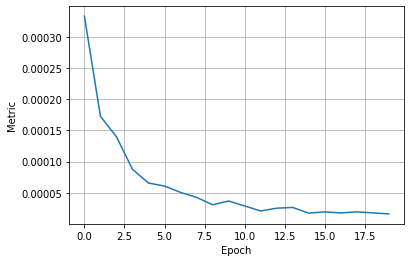

END OF EPOCH 19


In [119]:
#!g1.1

# TRAIN
for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)
    print(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)


In [120]:
#!g1.1
history['val_metric']

[0.00033323382447741814,
 0.00017266502171217594,
 0.00013983754246842535,
 8.756779320538016e-05,
 6.56012505592711e-05,
 6.074963437581914e-05,
 5.056303065484436e-05,
 4.267393275260144e-05,
 3.069706475729014e-05,
 3.673622290938532e-05,
 2.887696274504802e-05,
 2.075513048714135e-05,
 2.5218856077820403e-05,
 2.6436235784369235e-05,
 1.731185553283412e-05,
 1.9275178687023166e-05,
 1.759829781672796e-05,
 1.9358724353158868e-05,
 1.7705713673188154e-05,
 1.604673544563631e-05]

In [121]:
#!g1.1
torch.save(model, 'model_base_new.pth')

## Стриминг

In [214]:
#!g1.1
for i in range(len(train_set)):
    if train_set[i]['label'] == 1:
        print(i)
        break


37


In [500]:
#!g1.1
x_to_stream = melspec_val(torch.cat([train_set[0]['wav'], train_set[37]['wav'], train_set[2]['wav']]).cuda()).unsqueeze(0)

In [612]:
#!g1.1
    
class StreamingCRNN(CRNN):
    def __init__(self, config: TaskConfig, max_window_length, streaming_step_size, streaming_batch_size=1):
        super().__init__(config)
        self.max_window_length = max_window_length
        self.streaming_step_size = streaming_step_size
        self.window_buffer = deque()
        self.attention_alphas = deque()
        self.gru_outputs = deque()
        self.last_hidden_state = torch.zeros(config.gru_num_layers, streaming_batch_size, config.hidden_size).to(config.device)
        
    def forward(self, frames):
        new_frames_length = len(frames)
        self.window_buffer.extend(frames)
        if len(self.window_buffer) < self.config.kernel_size[1]:
            return None, False
        if len(self.window_buffer) <= self.config.kernel_size[1] + new_frames_length:
            frames_to_process = torch.stack(list(self.window_buffer), dim=0).permute(1, 2, 0)
        else:
            frames_to_process = torch.stack(list(self.window_buffer)[-(self.config.kernel_size[1] + new_frames_length - 1):], dim=0).permute(1, 2, 0)
        frames_to_process = frames_to_process.unsqueeze(1)
        conv_output = self.conv(frames_to_process).transpose(-1, -2)
        gru_output, self.last_hidden_state = self.gru(conv_output, self.last_hidden_state)
        self.gru_outputs.extend([gru_output[:, i, :].unsqueeze(1) for i in range(gru_output.shape[1])])
        gru_outputs_to_process = torch.cat(list(self.gru_outputs), dim=1)

        new_alphas = self.attention.energy(gru_output)
        self.attention_alphas.extend([new_alphas[:, i, :].unsqueeze(1) for i in range(new_alphas.shape[1])])
        alphas_to_process = torch.cat(list(self.attention_alphas), dim=1)
        alphas_to_process = torch.softmax(alphas_to_process, dim=-2)
        contex_vector = (gru_outputs_to_process * alphas_to_process).sum(dim=-2)
        output = self.classifier(contex_vector)
        
        num_to_pop = len(self.window_buffer) + self.streaming_step_size - self.max_window_length
        for i in range(num_to_pop):
            self.window_buffer.pop()
            
        num_hidden_vector_to_pop = (num_to_pop // self.config.stride[1]) * int(len(self.window_buffer) - self.config.kernel_size[1] > num_to_pop) + 1
        for i in range(num_hidden_vector_to_pop):
            self.attention_alphas.pop()
            self.gru_outputs.pop()
        return output, True

def frames2list(x):
    return [x[:, :, i] for i in range(x.shape[2])]
    
def stream(x, config, model_path, max_window_length, streaming_step_size, streaming_batch_size=1):
    model = StreamingCRNN(config, max_window_length, streaming_step_size, streaming_batch_size).to(config.device)
    model.load_state_dict(torch.load(model_path))
    assert(len(x.shape) == 3 and x.shape[0] == 1)
    assert(max_window_length >= config.kernel_size[1])
    outputs = []
    frames = []
    x = x.to(config.device)
    for i in range(0, x.shape[2], streaming_step_size):
        inp = frames2list(x[:, :, i:min(i+streaming_step_size, x.shape[2])])
        result, success = model(inp)
        if success:
            outputs.append(F.softmax(result, dim=-1)[0][1])
    return outputs

In [621]:
#!g1.1

outputs = stream(torch.cat([bad_x_to_stream_1, good_x_to_stream, bad_x_to_stream_2], axis=2), config, 'model_base.pth', 30, 10, 1)

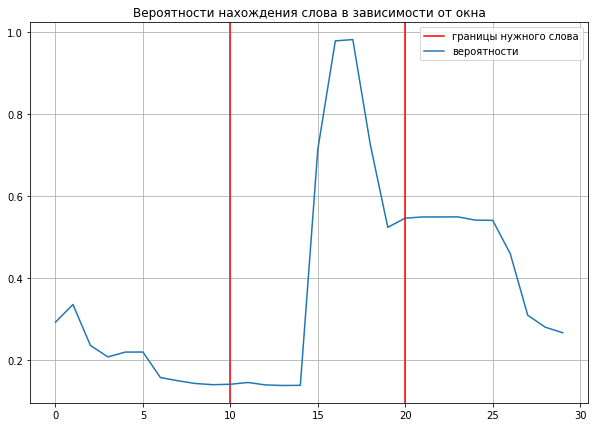

In [636]:
#!g1.1
plt.figure(figsize=(10, 7))
plt.grid()
plt.title('Вероятности нахождения слова в зависимости от окна')
plt.axvline(x = bad_x_to_stream_1.shape[2] // 10, color = 'r', linestyle = '-')
plt.plot(outputs)
plt.axvline(x = (bad_x_to_stream_1.shape[2] + good_x_to_stream.shape[2]) // 10, color = 'r', linestyle = '-')
plt.legend(['границы нужного слова', 'вероятности'])

# Ускоряемся


In [646]:
#!g1.1
from thop import profile

## Дистилляция


In [786]:
#!g1.1
# вспомним качество модели-учителя

config = TaskConfig()
teacher = CRNN(config).to(config.device)
teacher.load_state_dict(torch.load('model_base_new.pth'))



<All keys matched successfully>

In [ ]:
#!g1.1
validation(teacher, val_loader, melspec_val, config.device)

In [661]:
#!g1.1
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda' if torch.cuda.is_available() else 'cpu')

In [842]:
#!g1.1
config = TaskConfig()
config.cnn_out_channels = 3
config.kernel_size = (3, 20)
config.hidden_size = 20
config.gru_num_layers = 1
student = CRNN(config).to(config.device)

/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [663]:
#!g1.1
%pip install thop

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [805]:
#!g1.1


profile(teacher, (torch.randn(1, 40, 101).cuda(), ))  

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


(933808.0, 70443.0)

In [844]:
#!g1.1
933808 / 94952

9.834526918864269

In [843]:
#!g1.1
profile(student, (torch.randn(1, 40, 101).cuda(), ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


(96587.0, 5406.0)

### Самая обычная дистилляция, которую передают из поколения в поколение 

In [856]:
#!g1.1



def train_epoch_distillation(teacher, student, opt, loader, log_melspec, device, T=1, alpha=0.1):
    teacher.eval()
    student.train()
    KL = nn.KLDivLoss( reduction='batchmean')
    kls = []
    ces = []
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits_teacher = teacher(batch).detach()
        logits_student = student(batch)

        probs = F.softmax(logits_student, dim=-1)

        kl_loss = KL(F.log_softmax(logits_student/T, dim=1), F.softmax(logits_teacher/T, dim=1)) * alpha * T * T
        ce = F.cross_entropy(logits_student, labels) * (1. - alpha)
        loss = kl_loss + ce

        kls.append(kl_loss.detach().cpu().numpy())
        ces.append(ce.detach().cpu().numpy())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc, np.mean(kls), np.mean(ces)

In [845]:
#!g1.1
config = TaskConfig()
config.cnn_out_channels = 3
config.kernel_size = (3, 20)
config.hidden_size = 20
config.gru_num_layers = 1
student = CRNN(config).to(config.device)


opt = torch.optim.Adam(
    student.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [846]:
#!g1.1
sum([p.numel() for p in student.parameters()])

5406

In [847]:
#!g1.1
tearcher_metric = history['val_metric']

In [848]:
#!g1.1
student_metric_no_distill = []
train_kls = []
train_ces = []

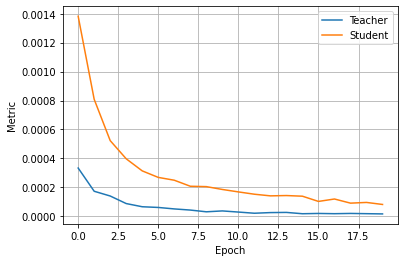

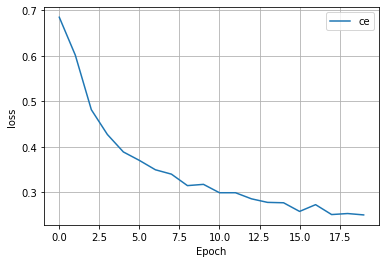

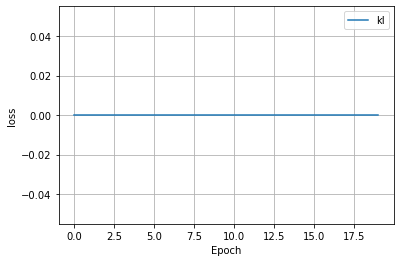

END OF EPOCH 19


In [849]:
#!g1.1

for n in range(TaskConfig.num_epochs):

    train_acc, train_kl, train_ce = train_epoch_distillation(teacher, student, opt, train_loader, melspec_train, config.device, T=10, alpha=0)

    au_fa_fr = validation(student, val_loader,
                          melspec_val, config.device)
    student_metric_no_distill.append(au_fa_fr)
    train_kls.append(train_kl)
    train_ces.append(train_ce)
    print(au_fa_fr)

    clear_output()
    plt.plot(tearcher_metric)
    plt.plot(student_metric_no_distill)
    plt.legend(['Teacher', 'Student'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    
    
    plt.plot(train_ces)
    plt.legend(['ce'])
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
        
    plt.plot(train_kls)
    plt.legend(['kl'])
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [850]:
#!g1.1
train_kls_no_distill = train_kls
train_ces_no_distill = train_ces

In [898]:
#!g1.1
import warnings
warnings.filterwarnings('ignore')

In [859]:
#!g1.1
config = TaskConfig()
config.cnn_out_channels = 3
config.kernel_size = (3, 20)
config.hidden_size = 20
config.gru_num_layers = 1
student = CRNN(config).to(config.device)


opt = torch.optim.Adam(
    student.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

student_metric = []
train_kls = []
train_ces = []

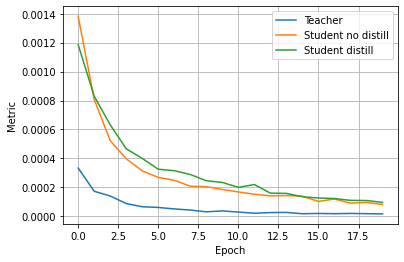

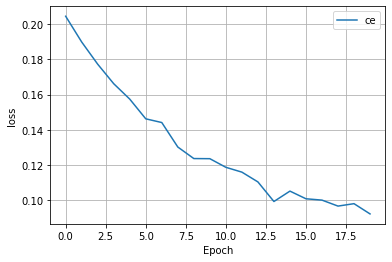

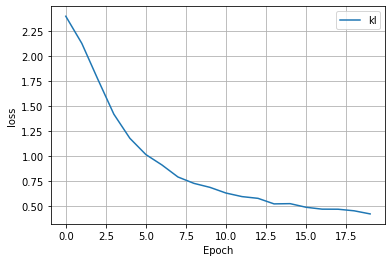

END OF EPOCH 19


In [860]:
#!g1.1
for n in range(TaskConfig.num_epochs):

    train_acc, train_kl, train_ce = train_epoch_distillation(teacher, student, opt, train_loader, melspec_train, config.device, T=10, alpha=0.7)

    au_fa_fr = validation(student, val_loader,
                          melspec_val, config.device)
    student_metric.append(au_fa_fr)
    train_kls.append(train_kl)
    train_ces.append(train_ce)
    print(au_fa_fr)

    clear_output()
    plt.plot(tearcher_metric)
    plt.plot(student_metric_no_distill)
    plt.plot(student_metric)
    plt.legend(['Teacher', 'Student no distill', 'Student distill'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    
    
    plt.plot(train_ces)
    plt.legend(['ce'])
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
        
    plt.plot(train_kls)
    plt.legend(['kl'])
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

### Attention distillation

In [1100]:
#!g1.1
print(1)

1


In [1101]:
#!g1.1
class ReturnAttentionCRNN(CRNN):
    def __init__(self, config: TaskConfig):
        super().__init__(config)
        
    def forward(self, x):
        
        x = x.unsqueeze(1)
        conv_output = self.conv(x).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)

        alphas = self.attention.energy(gru_output)
        alphas_softmax = torch.softmax(alphas, dim=-2)
        contex_vector = (gru_output * alphas_softmax).sum(dim=-2)
        output = self.classifier(contex_vector)
        return output, alphas


In [1102]:
#!g1.1
def train_epoch_attention_distillation(teacher, student, opt, loader, log_melspec, device, T=1, alpha=0.1):
    teacher.eval()
    student.train()
    KL = nn.KLDivLoss( reduction='batchmean')
    kls = []
    kls_attention = []
    ces = []
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits_teacher, teacher_alphas = teacher(batch)
        logits_teacher = logits_teacher.detach()
        teacher_alphas = teacher_alphas.detach()
        logits_student, student_alphas = student(batch)

        probs = F.softmax(logits_student, dim=-1)

        kl_loss = KL(F.log_softmax(logits_student/T, dim=1), F.softmax(logits_teacher/T, dim=1)) * alpha * T * T
        ce = F.cross_entropy(logits_student, labels) * (1. - alpha)
        kl_loss_attention =  KL(F.log_softmax(student_alphas/T, dim=1), F.softmax(teacher_alphas/T, dim=1)) * alpha * T * T
        loss = kl_loss + ce + kl_loss_attention

        kls.append(kl_loss.detach().cpu().numpy())
        ces.append(ce.detach().cpu().numpy())
        kls_attention.append(kl_loss_attention.detach().cpu().numpy())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc, np.mean(kls), np.mean(ces), np.mean(kls_attention)

@torch.no_grad()
def validation_attention_distillation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output, _ = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [1103]:
#!g1.1
config = TaskConfig()
teacher = ReturnAttentionCRNN(config).to(config.device)
teacher.load_state_dict(torch.load('model_base_new.pth'))

<All keys matched successfully>

In [1104]:
#!g1.1
config = TaskConfig()
config.cnn_out_channels = 3
config.kernel_size = (3, 20)
config.hidden_size = 20
config.gru_num_layers = 1
student = ReturnAttentionCRNN(config).to(config.device)


opt = torch.optim.Adam(
    student.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

student_metric = []
train_kls = []
train_ces = []
train_kl_ats = []

/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


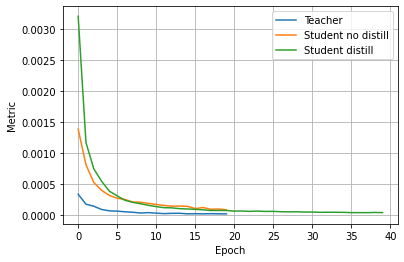

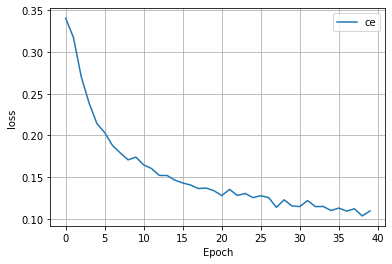

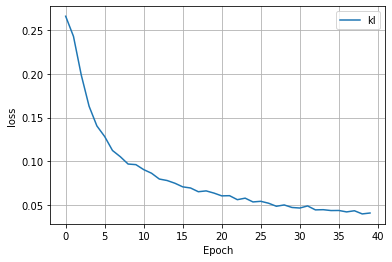

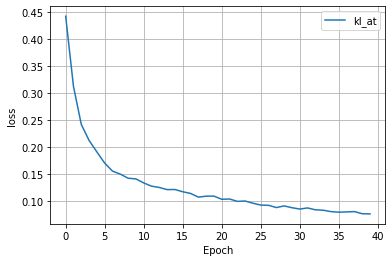

3.745829616670106e-05
END OF EPOCH 39


In [1105]:
#!g1.1
for n in range(2 * TaskConfig.num_epochs):

    train_acc, train_kl, train_ce, train_kl_at = train_epoch_attention_distillation(teacher, student, opt, train_loader, melspec_train, config.device, T=1, alpha=0.5)

    au_fa_fr = validation_attention_distillation(student, val_loader,
                          melspec_val, config.device)
    student_metric.append(au_fa_fr)
    train_kls.append(train_kl)
    train_ces.append(train_ce)
    train_kl_ats.append(train_kl_at)
    

    clear_output()
    plt.plot(tearcher_metric)
    plt.plot(student_metric_no_distill)
    plt.plot(student_metric)
    plt.legend(['Teacher', 'Student no distill', 'Student distill'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    
    
    plt.plot(train_ces)
    plt.legend(['ce'])
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
        
    plt.plot(train_kls)
    plt.legend(['kl'])
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    plt.plot(train_kl_ats)
    plt.legend(['kl_at'])
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    print(au_fa_fr)

    print('END OF EPOCH', n)

In [1106]:
#!g1.1
torch.save(student.state_dict(), 'good_student.pth')

In [1107]:
#!g1.1
Эта модель подходит под 10 раз быстрее и меньше и получает нужное качество.

SyntaxError: invalid syntax (<ipython-input-1-f905945a9c28>, line 1)

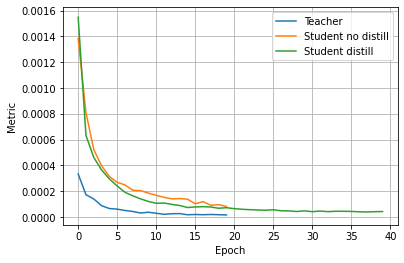

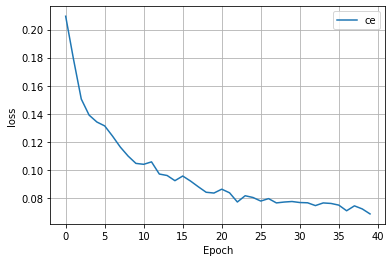

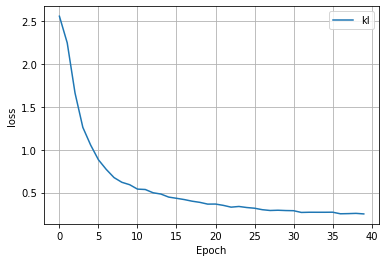

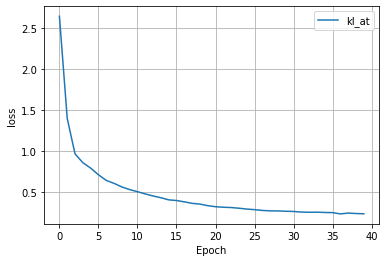

END OF EPOCH 39


In [902]:
#!g1.1
for n in range(2 * TaskConfig.num_epochs):

    train_acc, train_kl, train_ce, train_kl_at = train_epoch_attention_distillation(teacher, student, opt, train_loader, melspec_train, config.device, T=10, alpha=0.7)

    au_fa_fr = validation_attention_distillation(student, val_loader,
                          melspec_val, config.device)
    student_metric.append(au_fa_fr)
    train_kls.append(train_kl)
    train_ces.append(train_ce)
    train_kl_ats.append(train_kl_at)
    print(au_fa_fr)

    clear_output()
    plt.plot(tearcher_metric)
    plt.plot(student_metric_no_distill)
    plt.plot(student_metric)
    plt.legend(['Teacher', 'Student no distill', 'Student distill'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    
    
    plt.plot(train_ces)
    plt.legend(['ce'])
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
        
    plt.plot(train_kls)
    plt.legend(['kl'])
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    plt.plot(train_kl_ats)
    plt.legend(['kl_at'])
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

В этом эксперименте получилось хуже - 4.2e-5, забыл сделать принт.

Чтож, получилось взять модель, которая по памяти и времени, быстрее в 10 раз, но ведь смысл дз в том, чтобы еще что-то поисследовать?))) так что посмотрим еще всякие штуки


# Features distillation 

То есть дистиллируем не только эттеншн, а вообще почти все

## !g1.1


In [916]:
#!g1.1
class ReturnAllTeacherCRNN(CRNN):
    def __init__(self, config: TaskConfig):
        super().__init__(config)
        
    def forward(self, x):
        
        x = x.unsqueeze(1)
        conv_output = self.conv(x).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)

        alphas = self.attention.energy(gru_output)
        alphas_softmax = torch.softmax(alphas, dim=-2)
        contex_vector = (gru_output * alphas_softmax).sum(dim=-2)
        output = self.classifier(contex_vector)
        return output, alphas, gru_output, contex_vector


class ReturnAllStudentCRNN(CRNN):
    def __init__(self, config: TaskConfig, teacher_gru_hidden_state):
        super().__init__(config)
        # эти параметры нужны только для дистилляции!
        self.gru_projector = nn.Linear(config.hidden_size, teacher_gru_hidden_state)
        self.context_projector = nn.Linear(config.hidden_size, teacher_gru_hidden_state)
        
    def forward(self, x):
        
        x = x.unsqueeze(1)
        conv_output = self.conv(x).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        gru_projected = self.gru_projector(gru_output)

        alphas = self.attention.energy(gru_output)
        alphas_softmax = torch.softmax(alphas, dim=-2)
        contex_vector = (gru_output * alphas_softmax).sum(dim=-2)
        contex_vector_projected = self.context_projector(contex_vector)
        output = self.classifier(contex_vector)
        return output, alphas, gru_projected, contex_vector_projected
    
    
def train_epoch_features_distillation(teacher, student, opt, loader, log_melspec, device, T=1, alpha=0.1):
    teacher.eval()
    student.train()
    KL = nn.KLDivLoss( reduction='batchmean')
    mse = nn.MSELoss(reduction='mean')
    kls = []
    kls_attention = []
    features = []
    ces = []
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        result = teacher(batch)
        result = [r.detach() for r in result]
        logits_teacher, teacher_alphas, teachers_gru, teachers_context = result
        logits_student, student_alphas, student_gru, student_context = student(batch)

        probs = F.softmax(logits_student, dim=-1)

        kl_loss = KL(F.log_softmax(logits_student/T, dim=1), F.softmax(logits_teacher/T, dim=1)) * alpha * T * T
        ce = F.cross_entropy(logits_student, labels) * (1. - alpha)
        kl_loss_attention =  KL(F.log_softmax(student_alphas/T, dim=1), F.softmax(teacher_alphas/T, dim=1)) * alpha * T * T
        
        features_loss = mse(student_gru, teachers_gru) + mse(student_context, teachers_context)

        loss = kl_loss + ce + kl_loss_attention + 0.1 * features_loss

        kls.append(kl_loss.detach().cpu().numpy())
        ces.append(ce.detach().cpu().numpy())
        kls_attention.append(kl_loss_attention.detach().cpu().numpy())
        features.append(features_loss.detach().cpu().numpy())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc, np.mean(kls), np.mean(ces), np.mean(kls_attention), np.mean(features)

@torch.no_grad()
def validation_features_distillation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output, _, _, _ = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [917]:
#!g1.1

teacher_config = TaskConfig()
teacher = ReturnAllTeacherCRNN(teacher_config).to(teacher_config.device)
teacher.load_state_dict(torch.load('model_base_new.pth'))


config = TaskConfig()
config.cnn_out_channels = 3
config.kernel_size = (3, 20)
config.hidden_size = 20
config.gru_num_layers = 1
student = ReturnAllStudentCRNN(config, teacher_config.hidden_size).to(config.device)


opt = torch.optim.Adam(
    student.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

student_metric = []
train_kls = []
train_ces = []
train_kl_ats = []
train_features = []

/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


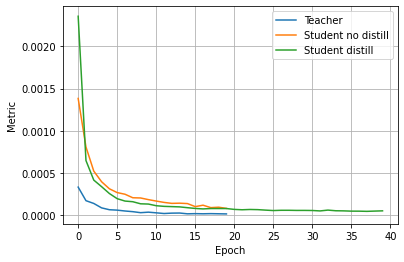

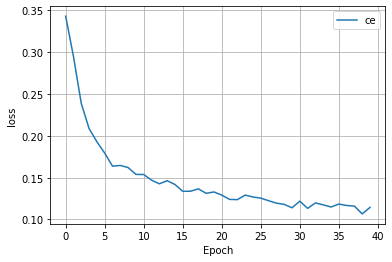

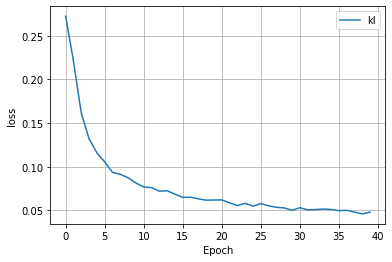

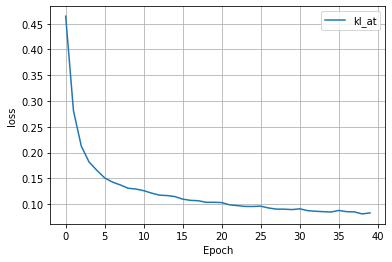

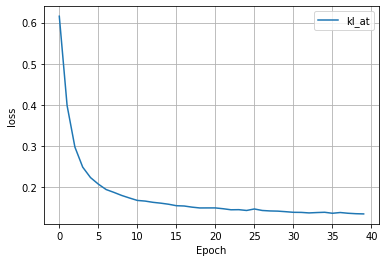

Metric:  5.242490550015434e-05
END OF EPOCH 39


In [918]:
#!g1.1
for n in range(2 * TaskConfig.num_epochs):

    train_acc, train_kl, train_ce, train_kl_at, train_feature = train_epoch_features_distillation(teacher, student, opt, train_loader, melspec_train, config.device, T=1, alpha=0.5)

    au_fa_fr = validation_features_distillation(student, val_loader,
                          melspec_val, config.device)
    student_metric.append(au_fa_fr)
    train_kls.append(train_kl)
    train_ces.append(train_ce)
    train_kl_ats.append(train_kl_at)
    train_features.append(train_feature)

    clear_output()
    plt.plot(tearcher_metric)
    plt.plot(student_metric_no_distill)
    plt.plot(student_metric)
    plt.legend(['Teacher', 'Student no distill', 'Student distill'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    
    
    plt.plot(train_ces)
    plt.legend(['ce'])
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
        
    plt.plot(train_kls)
    plt.legend(['kl'])
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    plt.plot(train_kl_ats)
    plt.legend(['kl_at'])
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    plt.plot(train_features)
    plt.legend(['kl_at'])
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    print("Metric: ", au_fa_fr)
    print('END OF EPOCH', n)

К сожалению, буста не дало. Попробуем что-нибудь другое.

# Quantization

Динамически заквантизуем лучшую маленькую модель после дистилляции.

In [1136]:
#!g1.1

class QuantCRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        #self.config = config
        #self.quant = torch.quantization.QuantStub()

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
        #self.dequant = torch.quantization.DeQuantStub()
    
    def forward(self, input):
        #input = self.quant(input)
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        #
        output = self.dequant(inoutputput)
        return output


config = TaskConfig()
config.cnn_out_channels = 3
config.kernel_size = (3, 20)
config.hidden_size = 20
config.gru_num_layers = 1
model = CRNN(config).to(config.device)

model_quant.load_state_dict(torch.load('good_student.pth'))


opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)


/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [1137]:
#!g1.1
model_int8 = torch.quantization.quantize_dynamic(
    model_quant.to('cpu'),  # the original model
    {nn.Linear, nn.Conv2d, nn.GRU},  # a set of layers to dynamically quantize
    dtype=torch.qint8)

/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/quantized/dynamic/modules/rnn.py:64: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [1121]:
#!g1.1
model_int8

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): DynamicQuantizedGRU(57, 20, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): DynamicQuantizedLinear(in_features=20, out_features=20, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
      (1): Tanh()
      (2): DynamicQuantizedLinear(in_features=20, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )
  )
  (classifier): DynamicQuantizedLinear(in_features=20, out_features=2, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [1123]:
#!g1.1
torch.save(model_int8.state_dict(), 'small_model.pth')

In [1122]:
#!g1.1
import os
os.path.getsize('good_student.pth')

82433

In [1124]:
#!g1.1
os.path.getsize('small_model.pth')

12399

Отлично, получилось малюсенькую модель сжать еще больше. Посмотрим, страдает ли как-то качество. По идее не должно так сильно, так как все промежуточные вычисления динамической квантизации происходят в итоге во флотах.

In [1132]:
#!g1.1

config = TaskConfig()
config.cnn_out_channels = 3
config.kernel_size = (3, 20)
config.hidden_size = 20
config.gru_num_layers = 1
config.device = 'cpu'

melspec_val = LogMelspec(is_train=False, config=config)

In [1138]:
#!g1.1
validation(model_int8, val_loader,
                          melspec_val, 'cpu')

102it [00:50,  2.04it/s]


3.9003890990211575e-05


Отлично, качество просело несильно, а мы умудрились снизить размер еще во много раз.